In [ ]:
!pip install indoNLP emoji nlpaug Sastrawi bertopic sentence-transformers minisom hdbscan optuna transformers torch

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import re
import nltk
import shutil
import warnings
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import tqdm.auto as tqdm
import spacy
import json
import logging
import os
import sys
import multiprocessing
import torch
import string

from sentence_transformers import SentenceTransformer
from umap import UMAP
from bertopic import BERTopic
from indoNLP.preprocessing import emoji_to_words, replace_slang, pipeline
from __future__ import print_function
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.word.context_word_embs as aug
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel
from transformers import pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from textblob import TextBlob
from nltk import ngrams

warnings.filterwarnings("ignore")

# **ETL**

In [ ]:
!unzip /content/data.zip -d /content/data

Archive:  /content/data.zip
   creating: /content/data/tweets-data/
  inflating: /content/data/tweets-data/kurikulum-merdeka-persen-part2.csv  
  inflating: /content/data/tweets-data/#kurikulum-merdeka-persen.csv  
  inflating: /content/data/tweets-data/kurikulum-merdeka-persen.csv  


In [ ]:
list_data = os.listdir('/content/data/tweets-data')

In [ ]:
data = [pd.read_csv(os.path.join("/content/data/tweets-data", data)) for data in list_data if data.endswith(".csv")]
df = pd.concat(data)

In [ ]:
df['opened_at'] = dt.datetime.now()

# **Pembersihan Data**

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import re
import emoji

def data_cleaning_pipeline(text: str):
    if not isinstance(text, str):
        text = str(text)

    def remove_emojis(input_text):
        return emoji.replace_emoji(input_text, replace='')

    step_1 = remove_emojis(text)
    step_2 = replace_slang(step_1)
    step_3 = re.sub(r'http\S+', '', step_2)
    step_4 = re.sub(r'\B[@#]\w+\b', '', step_3)
    step_6 = re.sub(r'\d+', '', step_4)
    step_7 = re.sub(r'\s+', ' ', step_6)

    words = step_7.split()
    step_8 = ' '.join(sorted(set(words), key=words.index))

    return step_8.strip().lower()

In [ ]:
df['full_text'] = df['full_text'].apply(data_cleaning_pipeline)
df.dropna(subset=["full_text"], inplace=True)
df.drop_duplicates(subset=['full_text'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df['full_text']

,full_text
0,mari kita ciptakan lingkungan sekolah yang ama...
1,tahukah kamu ternyata dalam kurikulum merdeka ...
2,kurikulum merdeka : arah baru pembelajaran yan...
3,menteri pendidikan dasar dan menengah abdul mu...
4,deep learning pengganti kurikulum merdeka begi...
...,...
4780,simak soal dan kunci jawaban bahasa indonesia ...
4781,lengkap soal dan rangkuman paibp kelas sama/sm...
4782,bisa ngkong di sekolah anak saya ada orang yan...
4783,kurikulum merdeka namanya jadi anak-anak engga...


In [ ]:
# for data in df['full_teks_clean']:
#     if not isinstance(data, str):
#         print(data)

In [ ]:
# df_kamus_alay = pd.read_csv('/content/kamusalay.csv', names=['alay', 'formal'], encoding='latin-1')
# df_kamus_kamus = pd.read_csv('/content/colloquial-indonesian-lexicon.csv').iloc[:, :2]
# df_new_alay = pd.read_csv('/content/new_kamusalay.csv', encoding="latin-1")
# df_kamus_kamus.columns = ['alay', 'formal']
# df_new_alay.columns = ['alay', 'formal']

In [ ]:
# with open("/content/daftar_baku_lantip.json", "r") as file:
#     data_lantip = json.load(file)

In [ ]:
# with open("/content/daftar_baku_ivanlanin.json", "r") as file:
#     data_ivan = json.load(file)

In [ ]:
# df_lantip = pd.DataFrame(list(data_lantip.items()), columns=['alay', 'formal'])
# df_ivan = pd.DataFrame(list(data_ivan.items()), columns=['alay', 'formal'])

In [ ]:
# df_full_kamus = pd.concat([df_kamus_alay, df_kamus_kamus, df_lantip, df_ivan])
# df_full_kamus.drop_duplicates(subset=['alay'], inplace=True)

In [ ]:
df_full_kamus = pd.read_csv('/content/kamus_lengkap.csv')

In [ ]:
list_teks = [teks for teks in df['full_text'].tolist()]
full_teks = "aaaagggggggaaa".join(list_teks)

In [ ]:
for index, row in df_full_kamus.iterrows():
    alay = re.escape(row['alay'])
    formal = row['formal']
    full_teks = re.sub(rf'\b{alay}\b[^\w]*', formal, full_teks)

In [ ]:
df['full_text_formal'] = full_teks.split("aaaagggggggaaa")

# **Pembersihan Lanjutan**

In [ ]:
list_teks = [teks for teks in df['full_text_formal'].tolist()]
full_teks_stop = "aaaagggggggaaa".join(list_teks)

In [ ]:
stop_1 = pd.read_csv('/content/stopwordbahasa.csv')
stop_2 = pd.read_csv('/content/stopwords_twitter.csv')
stop_1.columns = ['stopword']
stop_2.columns = ['stopword']
full_stop = pd.concat([stop_1, stop_2])

In [ ]:
full_stop.reset_index(drop=True, inplace=True)

In [ ]:
for index, row in full_stop.iterrows():
    alay = re.escape(row['stopword'])
    formal = ""
    full_teks_stop = re.sub(rf'\b{alay}\b[^\w]*', formal, full_teks_stop)

In [ ]:
df['full_text_formal_stop'] = full_teks_stop.split("aaaagggggggaaa")

# **Stem**

In [ ]:
!pip install stanza

import stanza

stanza.download("id")
nlp = stanza.Pipeline("id")

def lemmastanZa(teks):
  doc = nlp(teks)
  hasil = " ".join([word.lemma for sentence in doc.sentences for word in sentence.words])
  return hasil

df['full_text_formal_stop_stanza'] = df['full_text_formal_stop'].apply(lemmastanZa)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.0 MB/s eta 0:00:00


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: id (Indonesian) ...


INFO:stanza:Downloaded file to /root/stanza_resources/id/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: id (Indonesian):
| Processor    | Package      |
-------------------------------
| tokenize     | gsd          |
| mwt          | gsd          |
| pos          | gsd_charlm   |
| lemma        | gsd_nocharlm |
| constituency | icon_charlm  |
| depparse     | gsd_charlm   |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: constituency
INFO:stanza:Loading: depparse
INFO:stanza:Done loading processors!


In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def textStem(teks):
  hasil = stemmer.stem(teks)
  return hasil

df['full_text_formal_stop_stem'] = df['full_text_formal_stop'].apply(textStem)

In [ ]:
df[['full_text_formal_stop_stanza', 'full_text_formal_stop_stem']]

In [ ]:
df.to_csv('data.csv', index=False)

# **EDA**

In [ ]:
data = df.copy(deep=True)

In [ ]:
print(f"Jumlah baris: {data.shape[0]}, Jumlah kolom: {data.shape[1]}")
print(data.info())

print(data.isnull().sum())

Jumlah baris: 4785, Jumlah kolom: 20
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4785 entries, 0 to 4784
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   conversation_id_str           4785 non-null   int64         
 1   created_at                    4785 non-null   object        
 2   favorite_count                4785 non-null   int64         
 3   full_text                     4785 non-null   object        
 4   id_str                        4785 non-null   int64         
 5   image_url                     511 non-null    object        
 6   in_reply_to_screen_name       2761 non-null   object        
 7   lang                          4785 non-null   object        
 8   location                      2485 non-null   object        
 9   quote_count                   4785 non-null   int64         
 10  reply_count                   4785 non-null   int64        

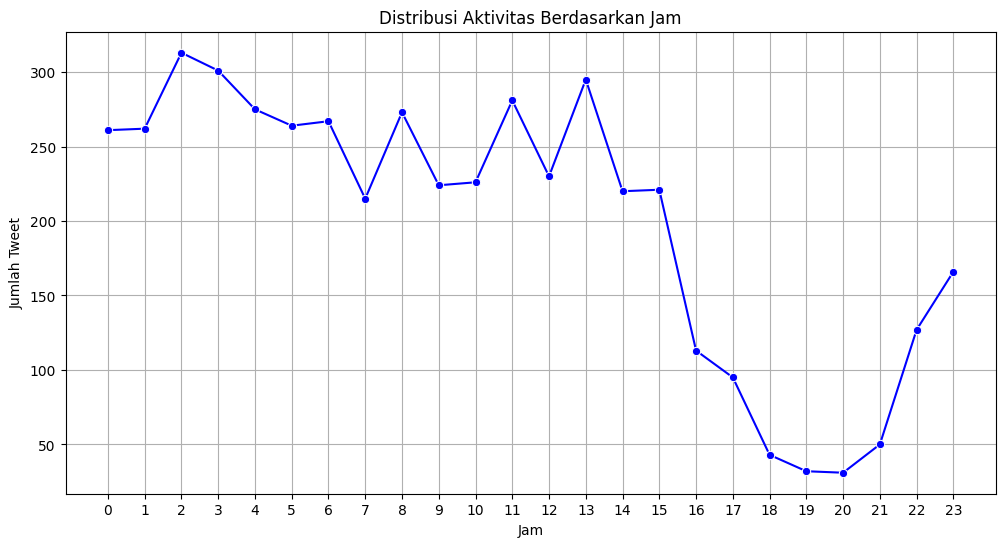

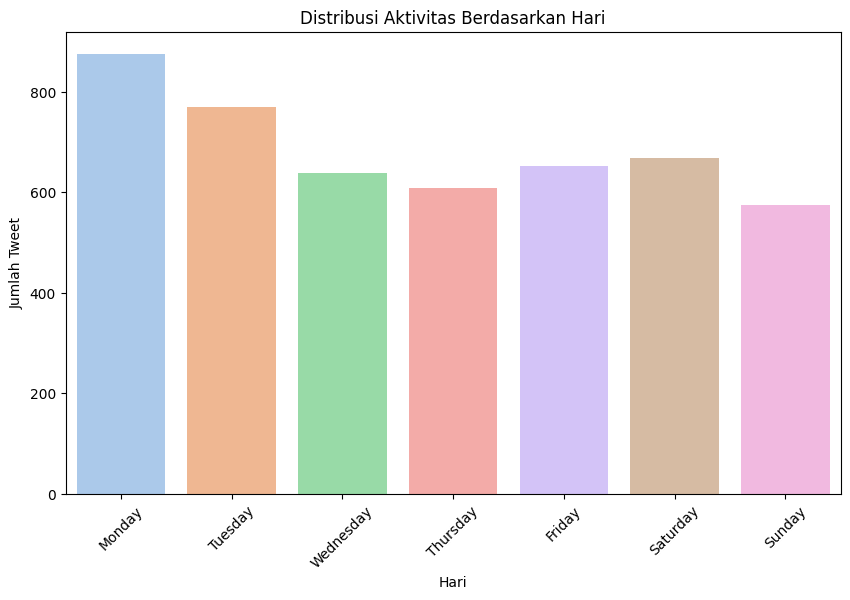

In [ ]:
# 1. Distribusi waktu (jam dan hari)
data['created_at'] = pd.to_datetime(data['created_at'], errors='coerce')
data['hour'] = data['created_at'].dt.hour
data['day_of_week'] = data['created_at'].dt.day_name()

# Aktivitas berdasarkan jam
hourly_activity = data['hour'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_activity.index, y=hourly_activity.values, marker='o', color='blue')
plt.title("Distribusi Aktivitas Berdasarkan Jam")
plt.xlabel("Jam")
plt.ylabel("Jumlah Tweet")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

# Aktivitas berdasarkan hari
daily_activity = data['day_of_week'].value_counts().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

plt.figure(figsize=(10, 6))
sns.barplot(x=daily_activity.index, y=daily_activity.values, palette="pastel")
plt.title("Distribusi Aktivitas Berdasarkan Hari")
plt.xlabel("Hari")
plt.ylabel("Jumlah Tweet")
plt.xticks(rotation=45)
plt.show()

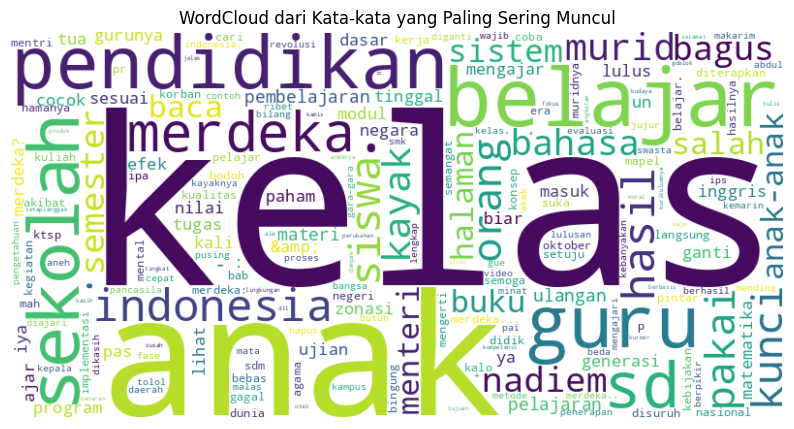

In [ ]:
text_data = ' '.join(data['full_text_formal_stop'].dropna().astype(str))

words = [word for word in text_data.split() if word.lower() not in stop_words and word.lower() not in ['merdeka', 'kurikulum']]


word_freq = Counter(words)

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud dari Kata-kata yang Paling Sering Muncul")
plt.show()

In [ ]:
def generate_ngrams(text, n):
    tokens = text.split()
    return list(ngrams(tokens, n))

text_data = ' '.join(data['full_text_formal_stop'].dropna().astype(str))

stop_words = set(stopwords.words('indonesian') + list(string.punctuation))
tokens = [word for word in text_data.split() if word.lower() not in stop_words and word.lower() not in ['merdeka', 'kurikulum']]

bigrams = list(ngrams(tokens, 2))
trigrams = list(ngrams(tokens, 3))

bigram_freq = Counter(bigrams)
trigram_freq = Counter(trigrams)

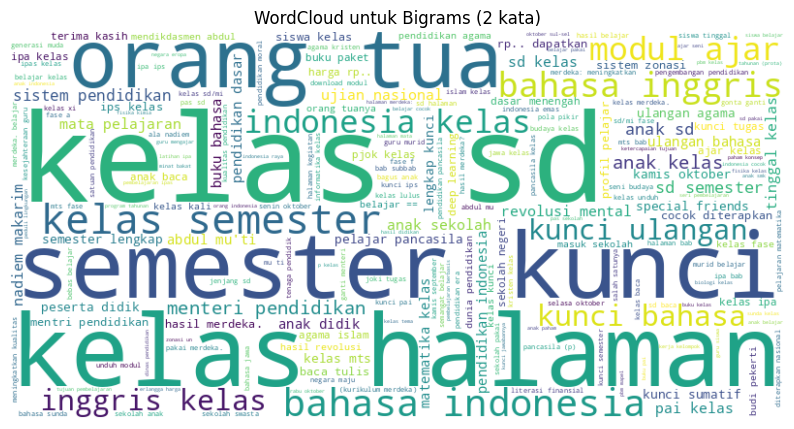

In [ ]:
bigram_wordcloud_data = {" ".join(k): v for k, v in bigram_freq.items()}

bigram_wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate_from_frequencies(bigram_wordcloud_data)

plt.figure(figsize=(10, 6))
plt.imshow(bigram_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud untuk Bigrams (2 kata)")
plt.show()

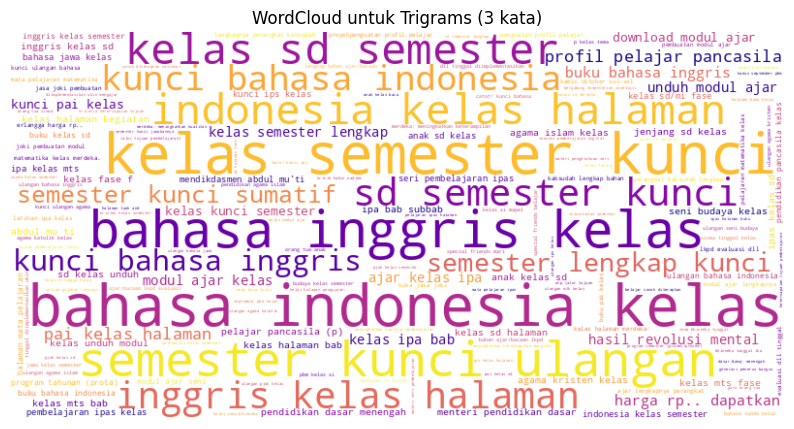

In [ ]:
trigram_wordcloud_data = {" ".join(k): v for k, v in trigram_freq.items()}

trigram_wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="plasma").generate_from_frequencies(trigram_wordcloud_data)

plt.figure(figsize=(10, 6))
plt.imshow(trigram_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud untuk Trigrams (3 kata)")
plt.show()

<Figure size 1000x600 with 0 Axes>

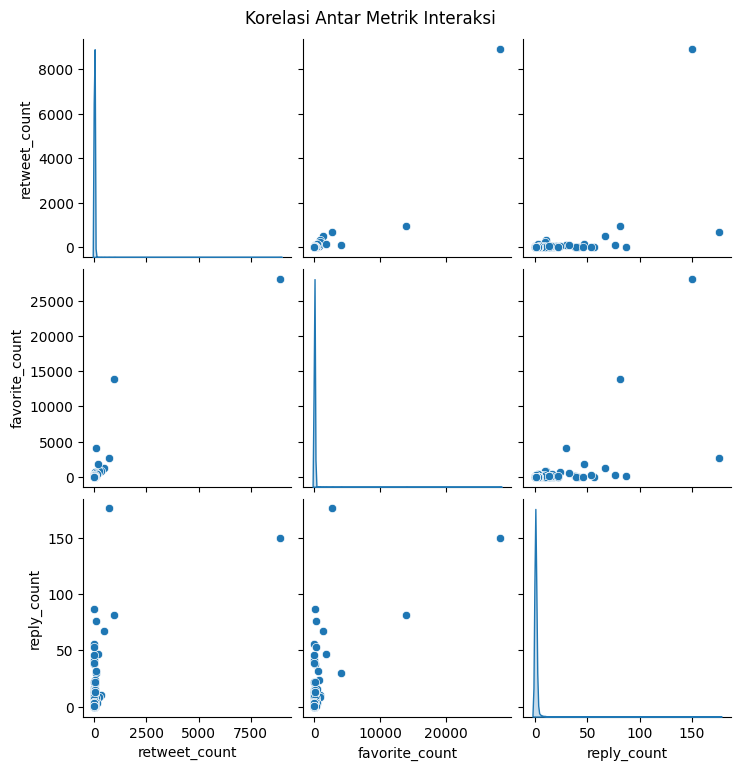

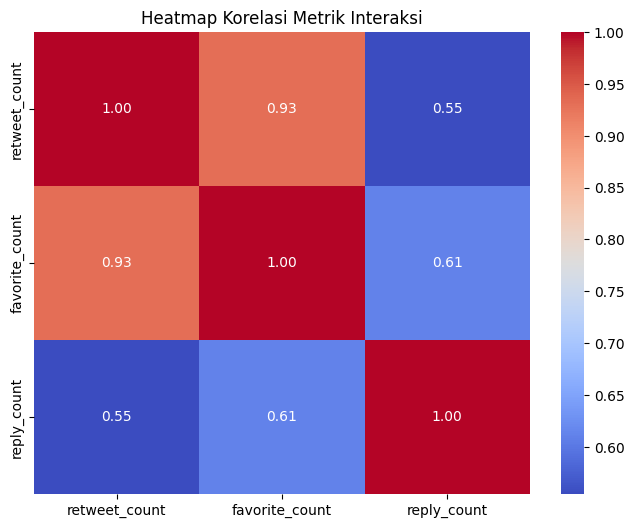

In [ ]:
plt.figure(figsize=(10, 6))
sns.pairplot(data, vars=['retweet_count', 'favorite_count', 'reply_count'], diag_kind="kde")
plt.suptitle("Korelasi Antar Metrik Interaksi", y=1.02)
plt.show()

correlation = data[['retweet_count', 'favorite_count', 'reply_count']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Heatmap Korelasi Metrik Interaksi")
plt.show()

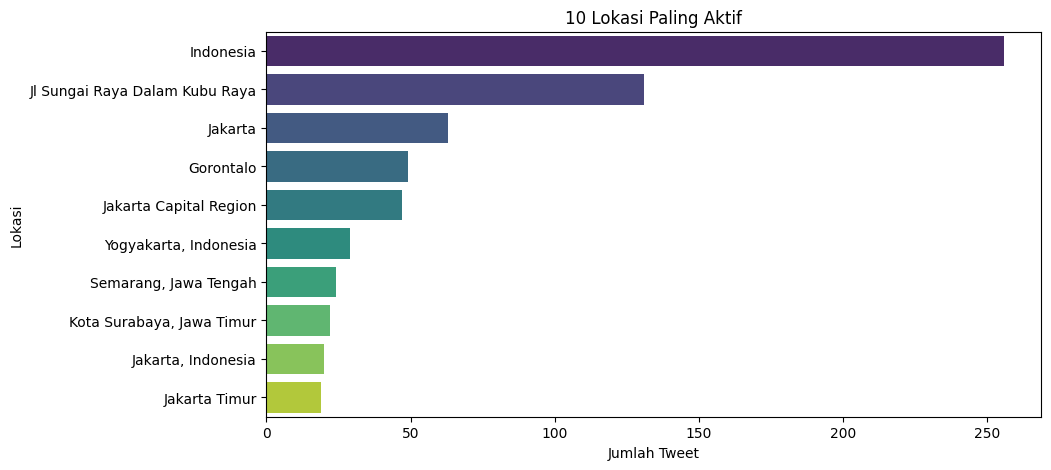

In [ ]:
top_locations = data['location'].dropna().value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_locations.values, y=top_locations.index, palette="viridis")
plt.title("10 Lokasi Paling Aktif")
plt.xlabel("Jumlah Tweet")
plt.ylabel("Lokasi")
plt.show()

In [ ]:
!pip install

import pandas as pd
import torch  # Import library to manage tensor types
from transformers import pipeline

# Load the pre-trained model and tokenizer
pretrained_name = "w11wo/indonesian-roberta-base-sentiment-classifier"
nlp = pipeline(
    "sentiment-analysis",
    model=pretrained_name,
    tokenizer=pretrained_name
)

# Ensure all text inputs are strings and handle empty cases
def analyze_sentiment(text):
    if pd.isnull(text) or not isinstance(text, str):  # Validate text input
        return {"label": "neutral", "score": 0.0}
    try:
        result = nlp(text)[0]  # Sentiment analysis on the text
    except Exception as e:
        print(f"Error processing text: {text}, Error: {e}")
        return {"label": "neutral", "score": 0.0}
    return result

# Assuming 'data' is a DataFrame with a 'full_text' column
data['full_text'] = data['full_text'].astype(str)  # Ensure all entries are strings
data['sentiment_result'] = data['full_text'].apply(analyze_sentiment)

# Extract the label and score
data['sentiment'] = data['sentiment_result'].apply(lambda x: x['label'])
data['sentiment_score'] = data['sentiment_result'].apply(lambda x: x['score'])

# Print results for verification
print(data[['full_text', 'sentiment', 'sentiment_score']].head())


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


                                           full_text sentiment  \
0  mari kita ciptakan lingkungan sekolah yang ama...   neutral   
1  tahukah kamu ternyata dalam kurikulum merdeka ...  positive   
2  kurikulum merdeka : arah baru pembelajaran yan...   neutral   
3  menteri pendidikan dasar dan menengah abdul mu...   neutral   
4  deep learning pengganti kurikulum merdeka begi...   neutral   

   sentiment_score  
0         0.911551  
1         0.812967  
2         0.975882  
3         0.998908  
4         0.998746  


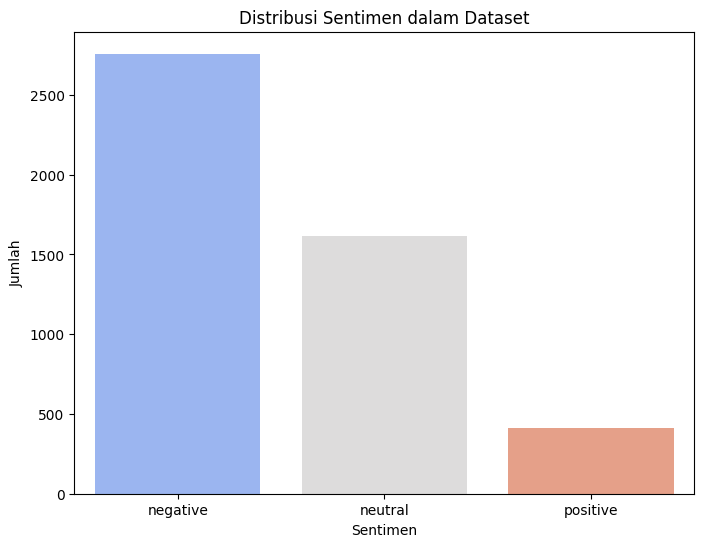

In [ ]:
sentiment_counts = data['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
plt.title("Distribusi Sentimen dalam Dataset")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.show()

In [ ]:
interaction_by_sentiment = data.groupby('sentiment')[['retweet_count', 'favorite_count', 'reply_count']].mean()

interaction_by_sentiment.plot(kind='bar', figsize=(10, 6), colormap="viridis")
plt.title("Rata-rata Interaksi Berdasarkan Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Rata-rata Interaksi")
plt.xticks(rotation=45)
plt.legend(title="Jenis Interaksi")
plt.show()

# **Topic Modeling**

In [ ]:
df = pd.read_csv('/content/data.csv')

In [ ]:
docs_pos = df[df['sentiment'] == 'positive']['full_text_formal_stop_stem'].reset_index(drop=True)

## **Positif Model**

In [ ]:
import optuna
from sentence_transformers import SentenceTransformer
from umap import UMAP
from sklearn.cluster import KMeans, AgglomerativeClustering
from hdbscan import HDBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

sentence_model = SentenceTransformer("all-mpnet-base-v2")
embeddings = sentence_model.encode(docs_pos)

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric="cosine", random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)

def objective_kmeans(trial):
    n_clusters = trial.suggest_int("n_clusters", 10, 100)
    init = trial.suggest_categorical("init", ["k-means++", "random"])
    max_iter = trial.suggest_int("max_iter", 100, 500)
    tol = trial.suggest_float("tol", 1e-6, 1e-3, log=True)

    kmeans = KMeans(
        n_clusters=n_clusters,
        init=init,
        max_iter=max_iter,
        tol=tol,
        random_state=42
    )
    labels = kmeans.fit_predict(reduced_embeddings)
    score = silhouette_score(reduced_embeddings, labels)
    return score

def objective_hdbscan(trial):
    min_cluster_size = trial.suggest_int("min_cluster_size",10, 100)
    min_samples = trial.suggest_int("min_samples", 1, 10)
    metric = trial.suggest_categorical("metric", ["euclidean", "manhattan"])
    cluster_selection_epsilon = trial.suggest_float("cluster_selection_epsilon", 0.0, 0.5)
    leaf_size = trial.suggest_int("leaf_size", 10, 50)

    hdbscan_model = HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric=metric,
        cluster_selection_epsilon=cluster_selection_epsilon,
        leaf_size=leaf_size
    )
    labels = hdbscan_model.fit_predict(reduced_embeddings)

    if len(set(labels)) > 1:
        filtered_embeddings = reduced_embeddings[labels != -1]
        filtered_labels = labels[labels != -1]
        score = silhouette_score(filtered_embeddings, filtered_labels)
    else:
        score = -1
    return score

def objective_agglomerative(trial):
    n_clusters = trial.suggest_int("n_clusters", 10, 100)
    linkage = trial.suggest_categorical("linkage", ["ward", "complete", "average", "single"])
    distance_threshold = trial.suggest_float("distance_threshold", 0.1, 10.0, step=0.1)

    agglomerative_model = AgglomerativeClustering(
        n_clusters=n_clusters,
        linkage=linkage,
        distance_threshold=None if n_clusters else distance_threshold
    )
    labels = agglomerative_model.fit_predict(reduced_embeddings)
    score = silhouette_score(reduced_embeddings, labels)
    return score

In [ ]:
study_kmeans = optuna.create_study(direction="maximize")
study_kmeans.optimize(objective_kmeans, n_trials=500)
print("Best KMeans Params:", study_kmeans.best_params)
print("Best KMeans Silhouette Score:", study_kmeans.best_value)

[I 2024-12-06 19:56:05,712] A new study created in memory with name: no-name-d8c0924d-c52c-4744-8dba-f408f15ba6b0
[I 2024-12-06 19:56:05,744] Trial 0 finished with value: 0.35258468985557556 and parameters: {'n_clusters': 68, 'init': 'random', 'max_iter': 329, 'tol': 0.0008600638049095056}. Best is trial 0 with value: 0.35258468985557556.
[I 2024-12-06 19:56:05,816] Trial 1 finished with value: 0.3532784581184387 and parameters: {'n_clusters': 20, 'init': 'k-means++', 'max_iter': 432, 'tol': 2.1257320466171324e-06}. Best is trial 1 with value: 0.3532784581184387.
[I 2024-12-06 19:56:05,945] Trial 2 finished with value: 0.3703403174877167 and parameters: {'n_clusters': 50, 'init': 'k-means++', 'max_iter': 232, 'tol': 0.0009291483010578119}. Best is trial 2 with value: 0.3703403174877167.
[I 2024-12-06 19:56:06,076] Trial 3 finished with value: 0.3390358090400696 and parameters: {'n_clusters': 79, 'init': 'random', 'max_iter': 345, 'tol': 4.2307460003419416e-05}. Best is trial 2 with val

Best KMeans Params: {'n_clusters': 14, 'init': 'random', 'max_iter': 403, 'tol': 1.7286656864199416e-05}
Best KMeans Silhouette Score: 0.4309062361717224


In [ ]:
study_hdbscan = optuna.create_study(direction="maximize")
study_hdbscan.optimize(objective_hdbscan, n_trials=500)
print("Best HDBSCAN Params:", study_hdbscan.best_params)
print("Best HDBSCAN Silhouette Score:", study_hdbscan.best_value)

[I 2024-12-06 19:57:13,859] A new study created in memory with name: no-name-13bd9146-e5f9-4498-831c-be1ae314ee55
[I 2024-12-06 19:57:13,885] Trial 0 finished with value: 0.48161354660987854 and parameters: {'min_cluster_size': 47, 'min_samples': 9, 'metric': 'euclidean', 'cluster_selection_epsilon': 0.49685154742815757, 'leaf_size': 14}. Best is trial 0 with value: 0.48161354660987854.
[I 2024-12-06 19:57:13,910] Trial 1 finished with value: 0.5700103044509888 and parameters: {'min_cluster_size': 41, 'min_samples': 10, 'metric': 'euclidean', 'cluster_selection_epsilon': 0.018326217690331048, 'leaf_size': 34}. Best is trial 1 with value: 0.5700103044509888.
[I 2024-12-06 19:57:13,942] Trial 2 finished with value: 0.48161354660987854 and parameters: {'min_cluster_size': 47, 'min_samples': 9, 'metric': 'euclidean', 'cluster_selection_epsilon': 0.1056351583218646, 'leaf_size': 15}. Best is trial 1 with value: 0.5700103044509888.
[I 2024-12-06 19:57:13,962] Trial 3 finished with value: 0.4

Best HDBSCAN Params: {'min_cluster_size': 34, 'min_samples': 6, 'metric': 'euclidean', 'cluster_selection_epsilon': 0.38131878494018484, 'leaf_size': 14}
Best HDBSCAN Silhouette Score: 0.6171959638595581


In [ ]:
study_agglomerative = optuna.create_study(direction="maximize")
study_agglomerative.optimize(objective_agglomerative, n_trials=500)
print("Best Agglomerative Clustering Params:", study_agglomerative.best_params)
print("Best Agglomerative Silhouette Score:", study_agglomerative.best_value)

[I 2024-12-06 19:57:43,480] A new study created in memory with name: no-name-ebc02a8f-54b2-4d90-ac66-192c980f6847
[I 2024-12-06 19:57:43,493] Trial 0 finished with value: 0.3761369585990906 and parameters: {'n_clusters': 55, 'linkage': 'complete', 'distance_threshold': 9.6}. Best is trial 0 with value: 0.3761369585990906.
[I 2024-12-06 19:57:43,509] Trial 1 finished with value: 0.4072396457195282 and parameters: {'n_clusters': 90, 'linkage': 'ward', 'distance_threshold': 1.3000000000000003}. Best is trial 1 with value: 0.4072396457195282.
[I 2024-12-06 19:57:43,526] Trial 2 finished with value: 0.37596726417541504 and parameters: {'n_clusters': 44, 'linkage': 'ward', 'distance_threshold': 7.1}. Best is trial 1 with value: 0.4072396457195282.
[I 2024-12-06 19:57:43,540] Trial 3 finished with value: -0.021089766174554825 and parameters: {'n_clusters': 49, 'linkage': 'single', 'distance_threshold': 5.3}. Best is trial 1 with value: 0.4072396457195282.
[I 2024-12-06 19:57:43,556] Trial 4 f

Best Agglomerative Clustering Params: {'n_clusters': 11, 'linkage': 'average', 'distance_threshold': 7.1}
Best Agglomerative Silhouette Score: 0.43870145082473755
